In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/A2FDA/32130_AT2_25971060.csv', encoding='utf-8-sig')


In [4]:
# ========== 2) 读取数据 & 变量类型设定 & 清洗 ==========

import numpy as np
# 统一去掉列名首尾空格
df.columns = [c.strip() for c in df.columns]

# id 列，删除以防信息泄漏
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# 归纳
# 名义（无序）：
nominal_cols = [c for c in [
    'Gender', 'Customer Type', 'Type of Travel', 'satisfaction'
] if c in df.columns]

# 有序（舱位 + Likert 0–5 评分）：
ordinal_cols = [c for c in [
    'Class', 'Inflight wifi service','Departure/Arrival time convenient','Ease of Online booking','Gate location',
    'Food and drink','Online boarding','Seat comfort','Inflight entertainment','On-board service',
    'Leg room service','Baggage handling','Checkin service','Inflight service','Cleanliness'
] if c in df.columns]

# 比率（连续、真零点）：
ratio_cols = [c for c in [
    'Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'
] if c in df.columns]

# 输出看看
print("Nominal:", nominal_cols)
print("Ordinal:", ordinal_cols)
print("Ratio:", ratio_cols)

# === 设定有序类别 ===
from pandas.api.types import CategoricalDtype

# 给舱位属性排个序
class_order = [c for c in ['Eco','Eco Plus','Business','First'] if c in df.get('Class', pd.Series(dtype=str)).unique().tolist()]
if len(class_order) > 0:
    df['Class'] = df['Class'].astype(CategoricalDtype(categories=class_order, ordered=True))

# 评分 0..5 设为有序（如果是数字或可转数字）
likert_cols = [c for c in ordinal_cols if c != 'Class']
for c in likert_cols:
    # 尝试转为整数评分
    df[c] = pd.to_numeric(df[c], errors='coerce')
    # 限定在 0..5 之间（异常值置为 NaN）
    df.loc[~df[c].isin([0,1,2,3,4,5]), c] = np.nan
    df[c] = df[c].astype('Int64')  # 可空整数
    # 保留有序类别副本（便于可视化排序）
    df[c] = df[c].astype(CategoricalDtype(categories=[0,1,2,3,4,5], ordered=True))

# satisfaction 清洗（统一大小写/空格）
if 'satisfaction' in df.columns:
    df['satisfaction'] = df['satisfaction'].astype(str).str.strip()
    # 二元化标签（供分组使用）
    df['satisfaction_bin'] = (df['satisfaction'].str.lower() == 'satisfied').astype(int)


Nominal: ['Gender', 'Customer Type', 'Type of Travel', 'satisfaction']
Ordinal: ['Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
Ratio: ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [5]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

# 工具函数：安全文件名，确保保存的文件名字没有空格
def sanitize(s: str) -> str:
    return ''.join([ch if ch.isalnum() else '_' for ch in str(s)]).strip('_')

# 为每个变量保存图表与表格的目录
BASE_OUT_DIR='/content/drive/MyDrive/A2FDA'
PLOTS_DIR = os.path.join(BASE_OUT_DIR, 'plots')
TABLES_DIR = os.path.join(BASE_OUT_DIR, 'tables')
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)


##Nominal和Ordinal的频数和百分比统计

In [ ]:

# ========== 3.1 计算汇总统计 ==========
attr_summary_rows = []

# --- Nominal / Ordinal: 频数、百分比---
# 返回众数及其频数，副作用生成一个存储所有信息的csv
def categorical_summary(col):
    s = df[col].dropna()
    freq = s.value_counts(dropna=False)
    pct = (freq / len(df)) * 100  # 用总体样本作分母，便于统一比较
    tab = pd.DataFrame({'Value': freq.index.astype(str), 'Count': freq.values, 'Percent': pct.values})
    tab_path = os.path.join(TABLES_DIR, f'{sanitize(col)}_frequencies.csv')
    tab.to_csv(tab_path, index=False)
    # 汇总要点
    top_val = freq.index[0] if len(freq) else None
    top_cnt = int(freq.iloc[0]) if len(freq) else 0
    missing = df[col].isna().sum()
    base = {
        'attribute': col,
        'type': 'categorical',
        'n': len(df),
        'n_missing': int(missing),
        'n_unique': int(s.nunique()),
        'top_value': str(top_val),
        'top_count': int(top_cnt),
        'table_path': tab_path
    }
    return base


In [ ]:
# --- Ordinal：补充中位数和分位数（注意：主要解读中位数和分布，而非均值） ---
def ordinal_extras(col):
    # 将类别转回数值以便计算分位数（1..5）
    s = pd.to_numeric(df[col], errors='coerce')
    if s.notna().sum() == 0:
        return {'median': None, 'p25': None, 'p75': None}
    return {
        'median': float(s.median()),
        'p25': float(s.quantile(0.25)),
        'p75': float(s.quantile(0.75))
    }


In [ ]:
# --- Ratio: mean, median, standard deviation, range, quartiles, skewness, kurtosis ---
def ratio_summary(col):
    s = pd.to_numeric(df[col], errors='coerce')
    desc = s.describe(percentiles=[0.25,0.5,0.75])

    missing_idx = s[s.isna()].index.tolist()  # Return the indices of missing values
    missing = s.isna().sum()

    zeros = int((s == 0).sum()) if s.notna().any() else 0
    return {
        'attribute': col,
        'type': 'ratio',
        'n': int(desc.get('count', 0)),
        'missing_idx': missing_idx,   # New: indices of missing values
        'n_missing': int(missing),
        'mean': float(desc.get('mean', np.nan)) if not np.isnan(desc.get('mean', np.nan)) else None,
        'median': float(desc.get('50%', np.nan)) if not np.isnan(desc.get('50%', np.nan)) else None,
        'std': float(desc.get('std', np.nan)) if not np.isnan(desc.get('std', np.nan)) else None,
        'min': float(desc.get('min', np.nan)) if not np.isnan(desc.get('min', np.nan)) else None,
        'p25': float(desc.get('25%', np.nan)) if not np.isnan(desc.get('25%', np.nan)) else None,
        'p75': float(desc.get('75%', np.nan)) if not np.isnan(desc.get('75%', np.nan)) else None,
        'max': float(desc.get('max', np.nan)) if not np.isnan(desc.get('max', np.nan)) else None,
        'n_zeros': zeros,
        'skew': float(s.skew()) if s.notna().sum() > 2 else None,
        'kurt': float(s.kurt()) if s.notna().sum() > 3 else None
    }


In [ ]:
# 逐列处理
for col in nominal_cols:
    base = categorical_summary(col)
    base['subtype'] = 'nominal'
    attr_summary_rows.append(base)

for col in ordinal_cols:
    base = categorical_summary(col)
    base['subtype'] = 'ordinal'
    base.update(ordinal_extras(col))
    attr_summary_rows.append(base)

for col in ratio_cols:
    attr_summary_rows.append(ratio_summary(col))

attr_summary = pd.DataFrame(attr_summary_rows)
attr_summary_path = os.path.join(TABLES_DIR, 'attribute_summary.csv')
attr_summary.to_csv(attr_summary_path, index=False)
display(attr_summary)
print("Saved:", attr_summary_path)

,attribute,type,n,n_missing,n_unique,top_value,top_count,table_path,subtype,median,p25,p75,missing_idx,mean,std,min,max,n_zeros,skew,kurt
0,Gender,categorical,16625,0,2.0,Female,8327.0,/content/drive/MyDrive/A2FDA/tables/Gender_fre...,nominal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Customer Type,categorical,16625,0,2.0,Loyal Customer,13535.0,/content/drive/MyDrive/A2FDA/tables/Customer_T...,nominal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Type of Travel,categorical,16625,0,2.0,Business travel,11525.0,/content/drive/MyDrive/A2FDA/tables/Type_of_Tr...,nominal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,satisfaction,categorical,16625,0,2.0,neutral or dissatisfied,9421.0,/content/drive/MyDrive/A2FDA/tables/satisfacti...,nominal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Class,categorical,16625,0,3.0,Business,7974.0,/content/drive/MyDrive/A2FDA/tables/Class_freq...,ordinal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Inflight wifi service,categorical,16625,0,6.0,3,4106.0,/content/drive/MyDrive/A2FDA/tables/Inflight_w...,ordinal,3.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Departure/Arrival time convenient,categorical,16625,0,6.0,4,4081.0,/content/drive/MyDrive/A2FDA/tables/Departure_...,ordinal,3.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Ease of Online booking,categorical,16625,0,6.0,3,3895.0,/content/drive/MyDrive/A2FDA/tables/Ease_of_On...,ordinal,3.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Gate location,categorical,16625,0,5.0,3,4586.0,/content/drive/MyDrive/A2FDA/tables/Gate_locat...,ordinal,3.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Food and drink,categorical,16625,0,6.0,4,3913.0,/content/drive/MyDrive/A2FDA/tables/Food_and_d...,ordinal,3.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved: /content/drive/MyDrive/A2FDA/tables/attribute_summary.csv


In [6]:
import pandas as pd
import os

# 假设你的 DataFrame 是 df
# 这里填入你的分类属性列表
categorical_cols = nominal_cols + ordinal_cols

# 存放最终长表格的行
long_table_rows = []

for col in categorical_cols:
    s = df[col].dropna()
    freq = s.value_counts(dropna=False)
    pct = (freq / len(df)) * 100

    for val, count, perc in zip(freq.index, freq.values, pct.values):
        row = {
            'Attribute': col,
            'Category': str(val),
            'Count': count,
            'Percent': round(perc, 2)
        }
        long_table_rows.append(row)

# 生成最终 DataFrame
long_table = pd.DataFrame(long_table_rows)

# 保存为 CSV 或 Excel
output_csv = os.path.join(TABLES_DIR, 'categorical_long_table.csv')
long_table.to_csv(output_csv, index=False)

output_excel = os.path.join(TABLES_DIR, 'categorical_long_table.xlsx')
long_table.to_excel(output_excel, index=False)

print("Saved long table to:", output_csv, "and", output_excel)


Saved long table to: /content/drive/MyDrive/A2FDA/tables/categorical_long_table.csv and /content/drive/MyDrive/A2FDA/tables/categorical_long_table.xlsx


In [ ]:
# ========== 3.2 可视化 ==========
def save_fig(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=150, bbox_inches='tight')
    plt.close(fig)

In [ ]:
# 条形图：名义/有序
for col in nominal_cols + ordinal_cols:
    fig, ax = plt.subplots(figsize=(6,4))
    order = None
    # 有序变量按类别顺序排序（Class 或 0..5）
    if col in ordinal_cols:
        if col == 'Class' and hasattr(df[col].dtype, 'categories') and df[col].dtype.ordered:
            order = df[col].dtype.categories
        elif col in likert_cols:
            order = [0,1,2,3,4,5]
    sns.countplot(data=df, x=col, order=order, ax=ax, color='#4C78A8')
    ax.set_title(f'Frequency of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')
    plot_path = os.path.join(PLOTS_DIR, f'{sanitize(col)}_bar.png')
    save_fig(fig, plot_path)

In [ ]:
# ------------------ Age ------------------
def plot_age(df, out_dir):
    col = 'Age'
    s = pd.to_numeric(df[col], errors='coerce').dropna()

    # 直方图 + KDE
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(s, kde=True, bins='auto', color='#72B7B2', ax=ax)
    ax.set_title('Age Distribution')
    ax.set_xlabel('Age'); ax.set_ylabel('Count')
    save_fig(fig, os.path.join(out_dir, 'Age_hist.png'))

    # 箱线图
    fig, ax = plt.subplots(figsize=(6,2.8))
    sns.boxplot(x=s, color='#E45756', ax=ax, showfliers=True)
    ax.set_title('Age Boxplot')
    ax.set_xlabel('Age')
    save_fig(fig, os.path.join(out_dir, 'Age_box.png'))
# ------------------ Flight Distance ------------------
def plot_flight_distance(df, out_dir):
    col = 'Flight Distance'
    s = pd.to_numeric(df[col], errors='coerce').dropna()

    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(s, kde=True, bins='auto', color='#4C78A8', ax=ax)
    ax.set_title('Flight Distance Distribution')
    ax.set_xlabel('Flight Distance'); ax.set_ylabel('Count')
    save_fig(fig, os.path.join(out_dir, 'Flight_Distance_hist.png'))

    fig, ax = plt.subplots(figsize=(6,2.8))
    sns.boxplot(x=s, color='#F28E2B', ax=ax, showfliers=True)
    ax.set_title('Flight Distance Boxplot')
    ax.set_xlabel('Flight Distance')
    save_fig(fig, os.path.join(out_dir, 'Flight_Distance_box.png'))

# ------------------ Departure Delay ------------------
def plot_departure_delay(df, out_dir):
    col = 'Departure Delay in Minutes'
    s = pd.to_numeric(df[col], errors='coerce').dropna()

    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(s, bins=np.arange(0, s.max()+5, 5), kde=False, color='#59A14F', ax=ax)
    ax.set_title('Departure Delay Distribution')
    ax.set_xlabel('Minutes'); ax.set_ylabel('Count')
    save_fig(fig, os.path.join(out_dir, 'Departure_Delay_hist.png'))

    fig, ax = plt.subplots(figsize=(6,2.8))
    sns.boxplot(x=s, color='#E45756', ax=ax, showfliers=True)
    ax.set_title('Departure Delay Boxplot')
    ax.set_xlabel('Minutes')
    save_fig(fig, os.path.join(out_dir, 'Departure_Delay_box.png'))

# ------------------ Arrival Delay ------------------
def plot_arrival_delay(df, out_dir):
    col = 'Arrival Delay in Minutes'
    s = pd.to_numeric(df[col], errors='coerce').dropna()

    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(s, bins=np.arange(0, s.max()+5, 5), kde=False, color='#F28E2B', ax=ax)
    ax.set_title('Arrival Delay Distribution')
    ax.set_xlabel('Minutes'); ax.set_ylabel('Count')
    save_fig(fig, os.path.join(out_dir, 'Arrival_Delay_hist.png'))

    fig, ax = plt.subplots(figsize=(6,2.8))
    sns.boxplot(x=s, color='#E45756', ax=ax, showfliers=True)
    ax.set_title('Arrival Delay Boxplot')
    ax.set_xlabel('Minutes')
    save_fig(fig, os.path.join(out_dir, 'Arrival_Delay_box.png'))

In [ ]:
# 调用各个 ratio 变量的绘图函数
plot_age(df, PLOTS_DIR)
plot_flight_distance(df, PLOTS_DIR)
plot_departure_delay(df, PLOTS_DIR)
plot_arrival_delay(df, PLOTS_DIR)

print("All ratio variable plots have been saved to:", PLOTS_DIR)


All ratio variable plots have been saved to: /content/drive/MyDrive/A2FDA/plots


In [ ]:
# 选取评分项列
likert_cols = [
    'Inflight wifi service','Departure/Arrival time convenient','Ease of Online booking',
    'Gate location','Food and drink','Online boarding','Seat comfort','Inflight entertainment',
    'On-board service','Leg room service','Baggage handling','Checkin service',
    'Inflight service','Cleanliness'
]

# satisfaction 转为数值
df['satisfaction_num'] = df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})


In [ ]:
def plot_spearman_corr(df, cols, out_dir):
    """
    绘制 Spearman 相关热力图并保存
    df: DataFrame
    cols: 用于计算相关性的列列表
    out_dir: 保存路径
    """
    # 计算 Spearman 相关矩阵
    corr = df[cols].corr(method='spearman')

    # 确保保存目录存在
    os.makedirs(out_dir, exist_ok=True)

    # 创建图
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0, ax=ax)
    ax.set_title("Spearman Correlation Heatmap")

    # 保存图
    save_fig(fig, os.path.join(out_dir, 'Spearman_Correlation_Heatmap.png'))
    return corr

In [ ]:
corr = plot_spearman_corr(df, likert_cols + ['satisfaction_num'], out_dir=PLOTS_DIR)


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_hclust_corr(corr, out_dir):
    """
    基于 Spearman 相关矩阵做层次聚类树
    corr: 相关矩阵 (DataFrame)
    out_dir: 输出目录
    """
    # 将相关性转为距离：越相关 → 距离越小
    dist = 1 - corr

    # linkage 聚类（ward / average / complete 都可以，这里用 average）
    Z = linkage(dist, method='average')

    # 画 dendrogram
    fig, ax = plt.subplots(figsize=(12, 6))
    dendrogram(
        Z,
        labels=corr.columns.tolist(),
        leaf_rotation=90,
        leaf_font_size=10,
        ax=ax
    )
    ax.set_title("Hierarchical Clustering Dendrogram (Spearman Correlation)")

    # 保存
    os.makedirs(out_dir, exist_ok=True)
    fig.savefig(os.path.join(out_dir, "Spearman_HClust_Dendrogram.png"), bbox_inches="tight")
    plt.close(fig)

# 调用示例
# 然后再做层次聚类
plot_hclust_corr(corr, out_dir=PLOTS_DIR)


/tmp/ipython-input-2964322527.py:16: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist, method='average')


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def run_kmeans_clustering(df, cluster_features, TABLES_DIR, PLOTS_DIR, K_min=2, K_max=10):
    """
    Perform K-Means clustering on the specified features and generate visualizations.

    df: Original DataFrame
    cluster_features: List of features to cluster
    TABLES_DIR, PLOTS_DIR: Paths to save results
    K_min, K_max: Range of K values for silhouette analysis
    """
    # ------------------ Encode categorical variables ------------------
    label_encoders = {}
    df_k = df[cluster_features].copy()
    for col in df_k.columns:
        if df_k[col].isna().any():  # Fill missing values only if they exist
            df_k[col] = df_k[col].fillna(df_k[col].median())
    for col in df_k.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df_k[col] = le.fit_transform(df_k[col].astype(str))
        label_encoders[col] = le

    # ------------------ Standardize features ------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_k)

    # ------------------ Silhouette analysis to find optimal K ------------------
    sil_scores = []
    for k in range(K_min, K_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"K={k}, Silhouette Score={score:.4f}")

    best_k = np.arange(K_min, K_max + 1)[np.argmax(sil_scores)]
    print(f"\nRecommended optimal K: {best_k} (Silhouette Score={max(sil_scores):.4f})")

    # ------------------ Run K-Means with the optimal K ------------------
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df_k['Cluster'] = kmeans.fit_predict(X_scaled)
    centers = kmeans.cluster_centers_

    # ------------------ Save clustering results ------------------
    os.makedirs(TABLES_DIR, exist_ok=True)
    cluster_results_path = os.path.join(TABLES_DIR, 'kmeans_cluster_results.csv')
    df_k.to_csv(cluster_results_path, index=False)
    print(f"Clustering results saved: {cluster_results_path}")

    # ------------------ PCA for 2D visualization ------------------
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    centers_pca = pca.transform(centers)

    os.makedirs(PLOTS_DIR, exist_ok=True)
    pca_plot_path = os.path.join(PLOTS_DIR, f'kmeans_pca_visualization_k{best_k}.png')

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df_k['Cluster'], cmap='viridis', alpha=0.6, s=50)
    plt.scatter(centers_pca[:,0], centers_pca[:,1], c='red', marker='x', s=200, label='Centroids')
    plt.title(f'K-Means Clustering (Optimal K={best_k})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"PCA visualization saved: {pca_plot_path}")

    # ------------------ Cluster centers heatmap ------------------
    centers_df = pd.DataFrame(centers, columns=cluster_features)
    centers_df['Cluster'] = range(best_k)
    heatmap_path = os.path.join(PLOTS_DIR, f'kmeans_cluster_centers_heatmap_k{best_k}.png')

    plt.figure(figsize=(10,4))
    sns.heatmap(centers_df[cluster_features], annot=True, cmap='RdBu_r', center=0)
    plt.title('Cluster Centers Heatmap')
    plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Cluster centers heatmap saved: {heatmap_path}")

    return df_k, centers_df, best_k



K=2, Silhouette Score=0.4666
K=3, Silhouette Score=0.5243
K=4, Silhouette Score=0.5085
K=5, Silhouette Score=0.5424
K=6, Silhouette Score=0.5849
K=7, Silhouette Score=0.5740
K=8, Silhouette Score=0.5706
K=9, Silhouette Score=0.5688
K=10, Silhouette Score=0.5697

Recommended optimal K: 6 (Silhouette Score=0.5849)
Clustering results saved: /content/drive/MyDrive/A2FDA/tables/kmeans_cluster_results.csv


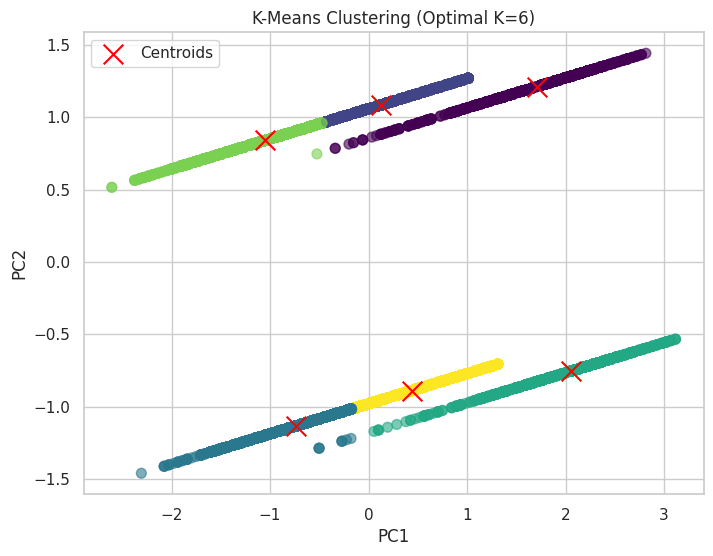

PCA visualization saved: /content/drive/MyDrive/A2FDA/plots/kmeans_pca_visualization_k6.png


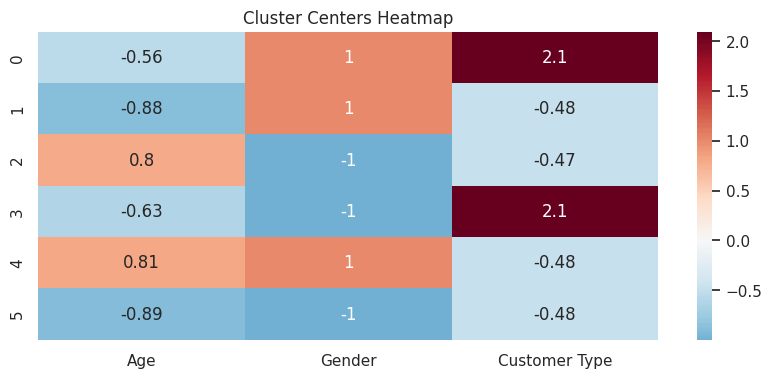

Cluster centers heatmap saved: /content/drive/MyDrive/A2FDA/plots/kmeans_cluster_centers_heatmap_k6.png
K=2, Silhouette Score=0.4550
K=3, Silhouette Score=0.5244
K=4, Silhouette Score=0.5947
K=5, Silhouette Score=0.5937
K=6, Silhouette Score=0.5972
K=7, Silhouette Score=0.6357
K=8, Silhouette Score=0.6399
K=9, Silhouette Score=0.6644
K=10, Silhouette Score=0.6547

Recommended optimal K: 9 (Silhouette Score=0.6644)
Clustering results saved: /content/drive/MyDrive/A2FDA/tables/kmeans_cluster_results.csv


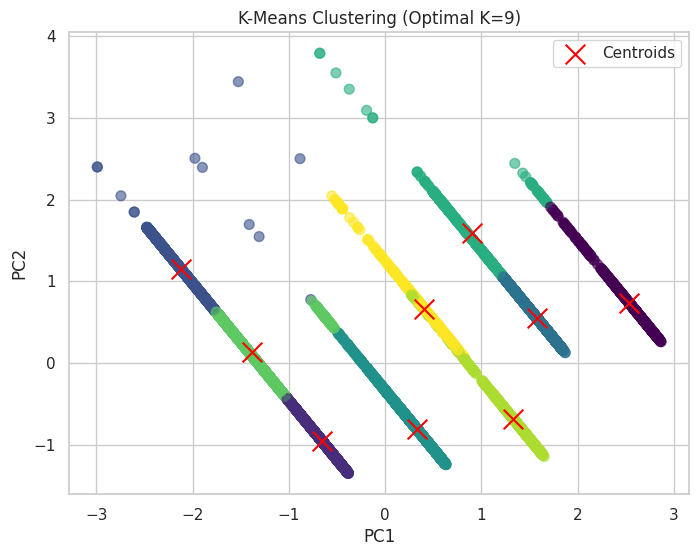

PCA visualization saved: /content/drive/MyDrive/A2FDA/plots/kmeans_pca_visualization_k9.png


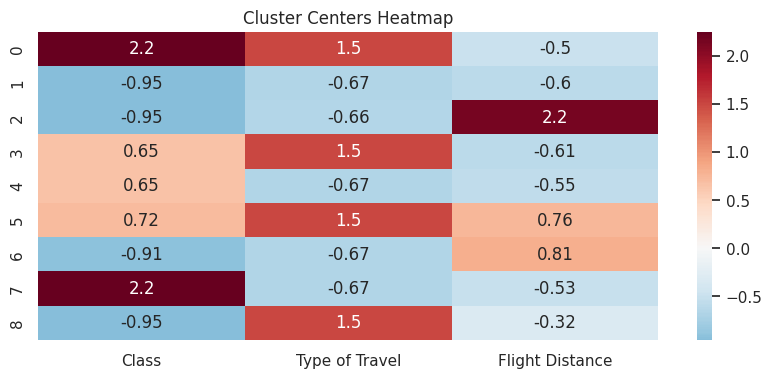

Cluster centers heatmap saved: /content/drive/MyDrive/A2FDA/plots/kmeans_cluster_centers_heatmap_k9.png
K=2, Silhouette Score=0.2384
K=3, Silhouette Score=0.2200
K=4, Silhouette Score=0.2309
K=5, Silhouette Score=0.2335
K=6, Silhouette Score=0.2338
K=7, Silhouette Score=0.2244
K=8, Silhouette Score=0.2251
K=9, Silhouette Score=0.2234
K=10, Silhouette Score=0.2246

Recommended optimal K: 2 (Silhouette Score=0.2384)
Clustering results saved: /content/drive/MyDrive/A2FDA/tables/kmeans_cluster_results.csv


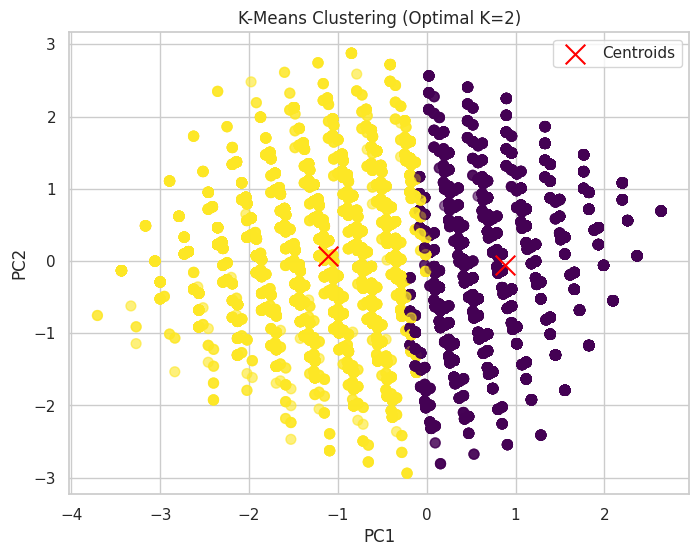

PCA visualization saved: /content/drive/MyDrive/A2FDA/plots/kmeans_pca_visualization_k2.png


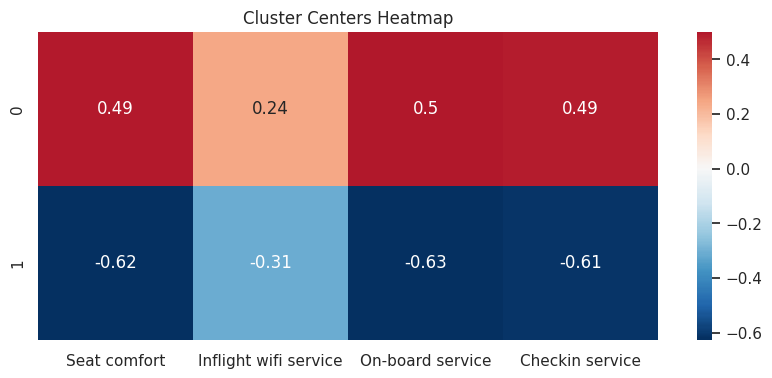

Cluster centers heatmap saved: /content/drive/MyDrive/A2FDA/plots/kmeans_cluster_centers_heatmap_k2.png
K=2, Silhouette Score=0.8623
K=3, Silhouette Score=0.8032
K=4, Silhouette Score=0.7714
K=5, Silhouette Score=0.7344
K=6, Silhouette Score=0.7308
K=7, Silhouette Score=0.7082
K=8, Silhouette Score=0.7000
K=9, Silhouette Score=0.6771
K=10, Silhouette Score=0.6822

Recommended optimal K: 2 (Silhouette Score=0.8623)
Clustering results saved: /content/drive/MyDrive/A2FDA/tables/kmeans_cluster_results.csv


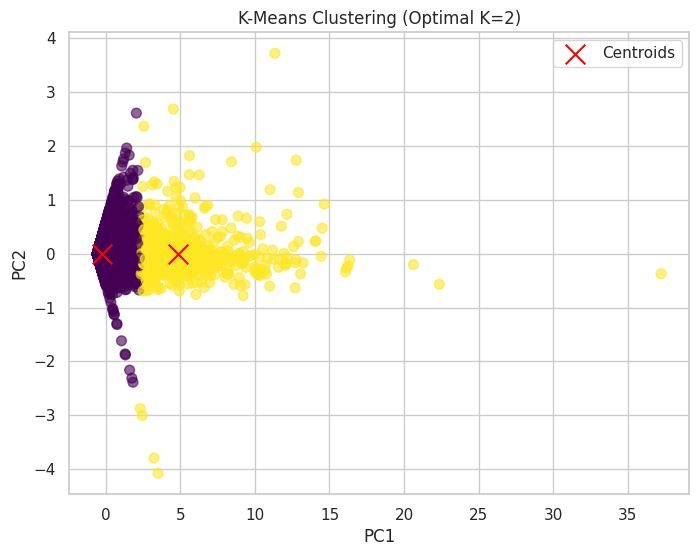

PCA visualization saved: /content/drive/MyDrive/A2FDA/plots/kmeans_pca_visualization_k2.png


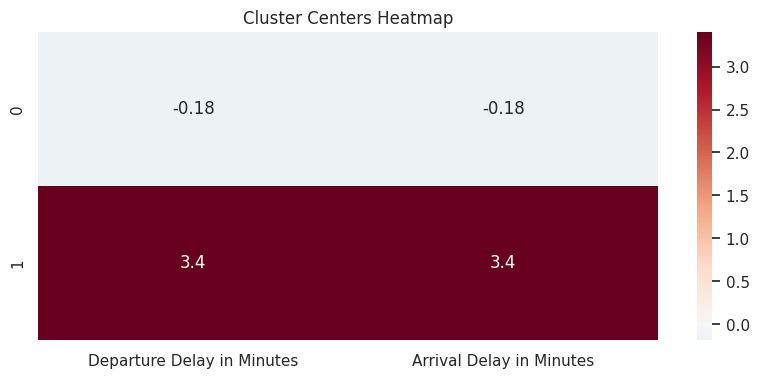

Cluster centers heatmap saved: /content/drive/MyDrive/A2FDA/plots/kmeans_cluster_centers_heatmap_k2.png


In [ ]:
# ------------------ 组1: 人口统计特征 ------------------
cluster_features_1 = ['Age', 'Gender', 'Customer Type']
df_clusters_1, centers_df_1, best_k_1 = run_kmeans_clustering(df, cluster_features_1, TABLES_DIR, PLOTS_DIR)

# ------------------ 组2: 行程特征 ------------------
cluster_features_2 = ['Class', 'Type of Travel', 'Flight Distance']
df_clusters_2, centers_df_2, best_k_2 = run_kmeans_clustering(df, cluster_features_2, TABLES_DIR, PLOTS_DIR)

# ------------------ 组3: 服务体验特征 ------------------
cluster_features_3 = ['Seat comfort', 'Inflight wifi service', 'On-board service', 'Checkin service']
df_clusters_3, centers_df_3, best_k_3 = run_kmeans_clustering(df, cluster_features_3, TABLES_DIR, PLOTS_DIR)

# ------------------ 组4: 客观延误指标 ------------------
cluster_features_4 = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
df_clusters_4, centers_df_4, best_k_4 = run_kmeans_clustering(df, cluster_features_4, TABLES_DIR, PLOTS_DIR)


In [ ]:
# 组合统计
combo_stats = df.groupby(['Online boarding', 'Inflight entertainment'])['satisfaction_num'].agg(['mean','count']).reset_index()
combo_stats = combo_stats.sort_values('mean')

# 全局满意度平均值
overall_mean_satisfaction = df['satisfaction_num'].mean()

# 找异常样本：OB >=4 或 IE >=4，但满意度低于平均
anomalies = df[((df['Online boarding'] >= 4) & (df['Inflight entertainment'] >= 4)) &
               (df['satisfaction_num'] < overall_mean_satisfaction)]

print("Identified Outlier Samples：")
print(anomalies[['Online boarding','Inflight entertainment','satisfaction_num']])

Identified Outlier Samples：
     Online boarding Inflight entertainment  satisfaction_num
10                 4                      4                 0
32                 4                      5                 0
45                 4                      4                 0
57                 4                      4                 0
66                 4                      4                 0
...              ...                    ...               ...
9320               4                      4                 0
9327               4                      4                 0
9364               4                      4                 0
9366               4                      4                 0
9367               4                      4                 0

[855 rows x 3 columns]


/tmp/ipython-input-1615484977.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combo_stats = df.groupby(['Online boarding', 'Inflight entertainment'])['satisfaction_num'].agg(['mean','count']).reset_index()


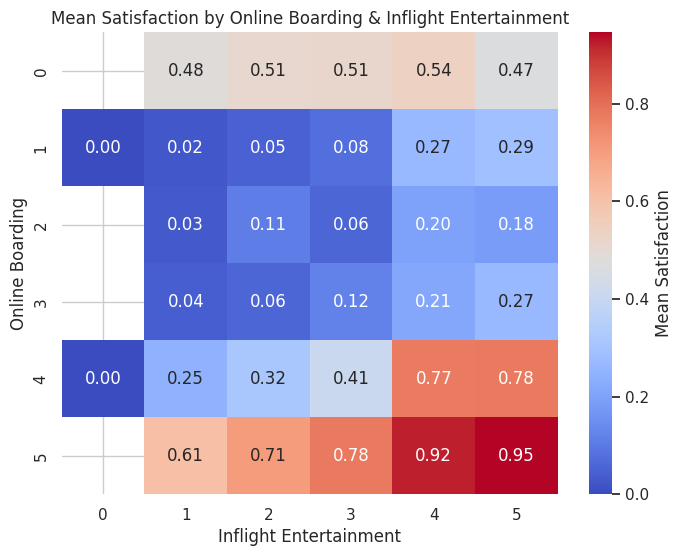

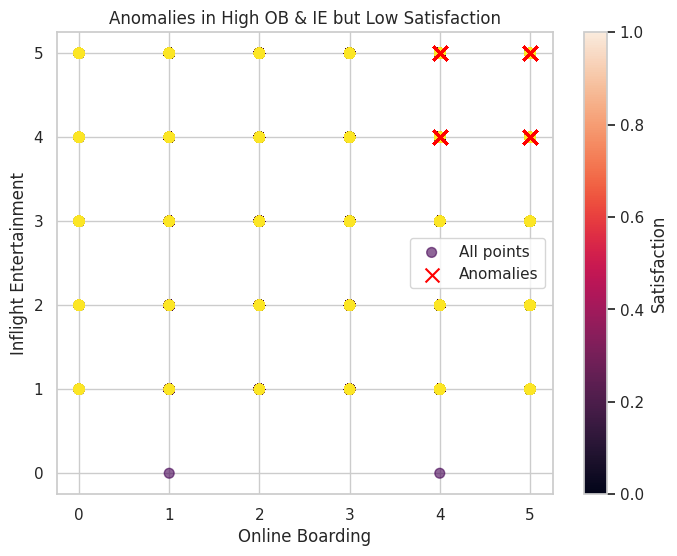

In [ ]:
# ------------------ 1. 组合均值热力图 ------------------
plt.figure(figsize=(8,6))
heatmap_data = combo_stats.pivot(index='Online boarding', columns='Inflight entertainment', values='mean')
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label':'Mean Satisfaction'})
plt.title('Mean Satisfaction by Online Boarding & Inflight Entertainment')
plt.xlabel('Inflight Entertainment')
plt.ylabel('Online Boarding')
plt.show()

# ------------------ 2. 异常点散点图 ------------------
plt.figure(figsize=(8,6))
# 所有点
plt.scatter(df['Online boarding'], df['Inflight entertainment'], c=df['satisfaction_num'],
            cmap='viridis', alpha=0.6, label='All points', s=50)
# 异常点
plt.scatter(anomalies['Online boarding'], anomalies['Inflight entertainment'],
            c='red', marker='x', s=100, label='Anomalies')
plt.colorbar(label='Satisfaction')
plt.xlabel('Online Boarding')
plt.ylabel('Inflight Entertainment')
plt.title('Anomalies in High OB & IE but Low Satisfaction')
plt.legend()
plt.show()

Detected anomalies:
Empty DataFrame
Columns: [Departure Delay in Minutes, Arrival Delay in Minutes]
Index: []


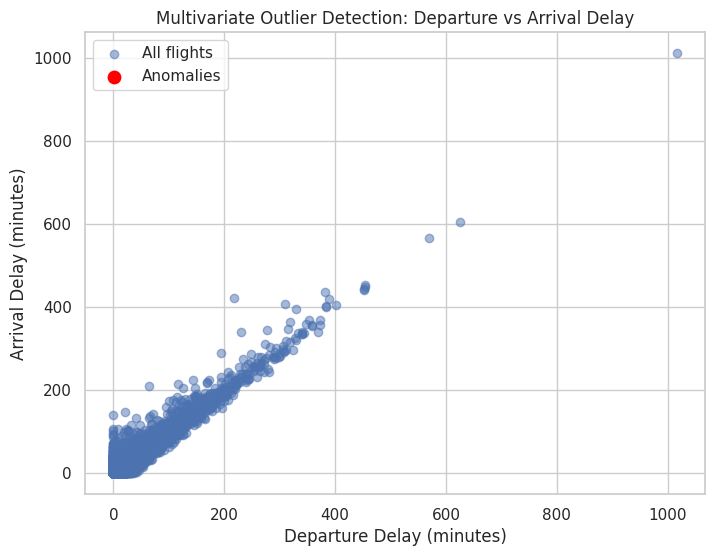

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 已经包含这两个字段
dep_mean = df['Departure Delay in Minutes'].mean()
dep_std = df['Departure Delay in Minutes'].std()
arr_mean = df['Arrival Delay in Minutes'].mean()
arr_std = df['Arrival Delay in Minutes'].std()

# 定义异常条件
anomalies = df[(df['Departure Delay in Minutes'] > dep_mean + 2*dep_std) &
               (df['Arrival Delay in Minutes'] < arr_mean)]

print("Detected anomalies:")
print(anomalies[['Departure Delay in Minutes', 'Arrival Delay in Minutes']])

# 可视化
plt.figure(figsize=(8,6))
plt.scatter(df['Departure Delay in Minutes'], df['Arrival Delay in Minutes'], alpha=0.5, label='All flights')
plt.scatter(anomalies['Departure Delay in Minutes'], anomalies['Arrival Delay in Minutes'],
            color='red', s=80, label='Anomalies')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Multivariate Outlier Detection: Departure vs Arrival Delay')
plt.legend()
plt.show()


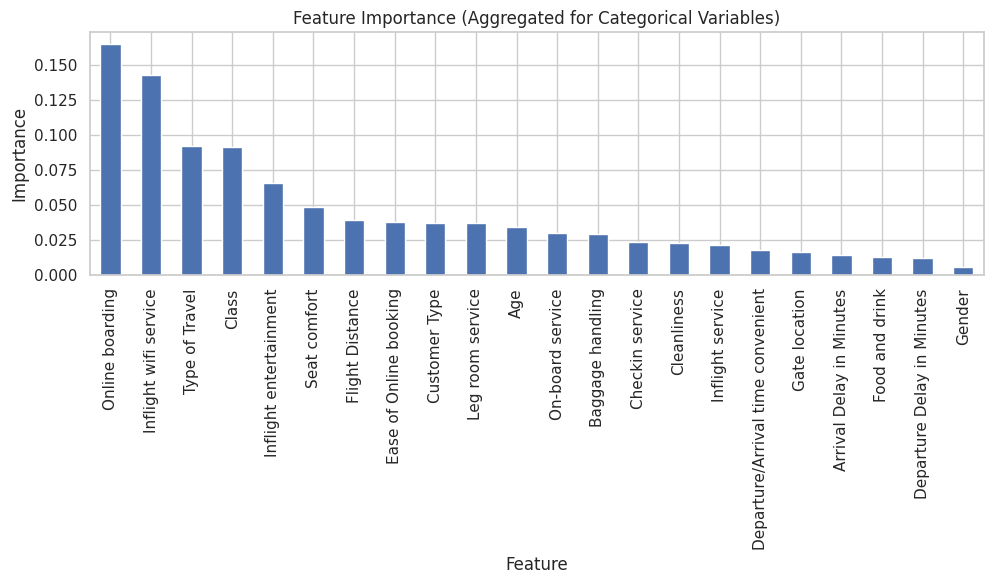

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 假设 df 是你的数据集，satisfaction_num 是二进制标签（0/1）

# ------------------ 1. 特征选择 ------------------
numerical_features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_features = ['Class', 'Inflight wifi service', 'Departure/Arrival time convenient',
                    'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
                    'Seat comfort', 'Inflight entertainment', 'On-board service',
                    'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service',
                    'Cleanliness']
nominal_features = ['Gender', 'Customer Type', 'Type of Travel']

all_features = numerical_features + ordinal_features + nominal_features

X = df[all_features].copy()
y = df['satisfaction_num']

# ------------------ 2. 编码 ------------------
# Ordinal features -> LabelEncoder
for col in ordinal_features:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Nominal features -> One-Hot Encoding
X_ohe = pd.get_dummies(X[nominal_features], drop_first=True)
X_numeric = X[numerical_features + ordinal_features].reset_index(drop=True)
X_final = pd.concat([X_numeric, X_ohe.reset_index(drop=True)], axis=1)

# ------------------ 3. 划分训练集 ------------------
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# ------------------ 4. 随机森林训练 ------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# ------------------ 5. 特征重要性 ------------------
importances = pd.Series(rf.feature_importances_, index=X_final.columns)

# ------------------ 6. 合并同一原始属性的独热列 ------------------
merged_importances = {}
for col in X.columns:
    if col in nominal_features:
        ohe_cols = [c for c in importances.index if c.startswith(col + "_")]
        merged_importances[col] = importances[ohe_cols].sum()
    else:
        merged_importances[col] = importances[col]

merged_importances = pd.Series(merged_importances).sort_values(ascending=False)

# ------------------ 7. 可视化 ------------------
plt.figure(figsize=(10,6))
merged_importances.plot(kind='bar')
plt.title("Feature Importance (Aggregated for Categorical Variables)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


